We now have our ready encoder architecture, now we need to make the decoder which takes input of encoders and then preidcting out the predictions for our reactions which will predict the reagent, solvent and catalyst in this case

# Importing Libraries

In [ ]:
!pip install torch-geometric rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 44.6 MB/s eta 0:00:00


In [53]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import spacy
# import fasttext

import torch
import torch.nn as nn
import torchtext
import torch.nn.functional as F
from torch.utils.data import Dataset,dataloader
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence,pad_sequence

from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import r2_score

In [ ]:
from rdkit import RDLogger

Chem.MolFromSmiles('c1cncc1')
RDLogger.DisableLog('rdApp.*')
Chem.MolFromSmiles('c1cncc1')

[16:30:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Importing Dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Chiros Dataset/choriso_public.tsv',sep='\t')
df.head()

,canonic_rxn,rxnmapper_aam,reagent,solvent,catalyst,yield
0,CCO.O=S1(=O)C=Cc2ccccc21.[H][H].[Pd]>>O=S1(=O)...,CCO.[O:1]=[S:2]1(=[O:3])[CH:4]=[CH:5][c:6]2[cH...,hydrogen,ethanol,palladium on activated charcoal,100.0
1,O=S1(=O)C=Cc2ccccc21.[Na+].[OH-].[Zn]>>O=S1(=O...,[O:1]=[S:2]1(=[O:3])[CH:4]=[CH:5][c:6]2[cH:7][...,sodium hydroxide|zinc,empty,empty,0.0
2,CCO.O=S1(=O)C=Cc2ccccc21.[Pd]>>O=S1(=O)CCc2ccc...,CCO.[O:1]=[S:2]1(=[O:3])[CH:4]=[CH:5][c:6]2[cH...,palladium on activated charcoal|ethanol,empty,empty,0.0
3,CO.O=C1CCCN1C1CCN(Cc2ccccc2)CC1.O=C[O-].[NH4+]...,CO.[O:1]=[C:2]1[CH2:3][CH2:4][CH2:5][N:6]1[CH:...,palladium 10 on activated carbon|ammonium formate,methanol,empty,100.0
4,CC(C)(C)OC(=O)N1CC2CC(CN(Cc3ccccc3)C2)C1.CCO.[...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,hydrogen,ethanol,palladium on activated charcoal,51.0


# Features File

In [ ]:
def featurize_molecule(mol):
    # Compute Morgan fingerprints for each atom
    atom_features = []
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        atom_feature = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, atomIndices=[idx])
        atom_features.append(np.array(atom_feature))

    return np.array(atom_features)

In [ ]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates for visualization
    AllChem.EmbedMolecule(mol, randomSeed=42)  # You can choose any seed value

    # Get atom features and adjacency matrix
    num_atoms = mol.GetNumAtoms()
    atom_features = np.zeros((num_atoms, 3))  # You may need to adjust the feature dimensions
    adjacency_matrix = np.zeros((num_atoms, num_atoms))

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1  # Adjacency matrix is symmetric

    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        atom_features[idx, 0] = atom.GetAtomicNum()  # Atom type or atomic number
        atom_features[idx, 1] = atom.GetTotalNumHs()  # Number of hydrogen atoms
        atom_features[idx, 2] = atom.GetFormalCharge()  # Formal charge

    # Convert to PyTorch tensors
    atom_features = torch.tensor(atom_features, dtype=torch.float)

    # Create edge_index using the adjacency matrix
    edge_index = torch.tensor(np.column_stack(np.where(adjacency_matrix)), dtype=torch.long)

    # Create PyTorch Geometric data object
    data = Data(x=atom_features, edge_index=edge_index.t().contiguous())  # Transpose edge_index

    return data

# GCN

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, input_size, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.encoding = nn.Embedding(max_len, input_size)

    def forward(self, x):
        x = x.to(device)
        positions = torch.arange(0, x.size(1), device=device).unsqueeze(0)
        positions = positions.expand(x.size(0), -1)  # Expand along the batch dimension
        positions = positions.to(device)
        return x + self.encoding(positions)

In [ ]:
class DistanceAttentionEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DistanceAttentionEncoder, self).__init__()

        self.embedding = PositionalEncoding(input_size)
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

    def pairwise_distances(self, x):
        distances = torch.norm(x[:, None, :] - x, dim=-1, p=2)
        return distances

    def forward(self, input_sequence):
        embedded_sequence = self.embedding(input_sequence)
        encoded_sequence = self.encoder(embedded_sequence)
        attention_scores = self.decoder(torch.tanh(encoded_sequence))
        attention_weights = self.softmax(attention_scores)
        context_vector = torch.sum(encoded_sequence * attention_weights, dim=1)

        return context_vector

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, out_channels, attention_heads=1):
        super().__init__()
        self.W_q = nn.Linear(in_channels, out_channels)
        self.W_k = nn.Linear(in_channels, out_channels)
        self.W_v = nn.Linear(in_channels, out_channels)
        self.attention_heads = attention_heads

    def forward(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = q.view(-1, self.attention_heads, q.size(-1))
        k = k.view(-1, self.attention_heads, k.size(-1))
        v = v.view(-1, self.attention_heads, v.size(-1))

        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(q.size(-1), dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, v).view(x.size(0), -1)

        return attention_output


In [ ]:
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, external_attention_heads=None):
        super(GATModel, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.external_attention = MultiHeadAttention(hidden_channels * heads, hidden_channels, attention_heads=external_attention_heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.external_attention_heads = external_attention_heads

    def forward(self, data):
        data = data.to(device)
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        if self.external_attention_heads is not None:
            external_attention_output = self.external_attention(x)
            x = torch.cat([x, external_attention_output], dim=-1)

        x = self.conv2(x, edge_index)

        self.distance_attention_encoder = DistanceAttentionEncoder(x.size(1), hidden_size=64).to(device)
        distance_attention_output = self.distance_attention_encoder(x.unsqueeze(0))

        return x


# Seperating compunds in the SMILES

In [ ]:
def separate_compounds(smiles_reaction):
    # Split the reaction string using '>>' as the separator
    compounds = smiles_reaction.split(">>")

    # Ensure that there are exactly two compounds
    if len(compounds) == 2:
        reactant = compounds[0].strip()
        product = compounds[1].strip()
        return reactant, product
    else:
        raise ValueError("Invalid SMILES reaction format. Expected one '>>' separator.")

# Given SMILES reaction
smiles_reaction = "O=C1CCCN1C1CCN(Cc2ccccc2)CC1>>O=C1CCCN1C1CCNCC1"

# Separate compounds
reactant, product = separate_compounds(smiles_reaction)

# Print the separated compounds
print("Reactant:", reactant)
print("Product:", product)


Reactant: O=C1CCCN1C1CCN(Cc2ccccc2)CC1
Product: O=C1CCCN1C1CCNCC1


# Cross Attention for both
Using cross attention to concatenate for both the compounds into a single embedding space

In [ ]:
def concatenate_with_cross_attention(emb1, emb2, out_channels, heads):
    if emb1.shape[0] > emb2.shape[0]:
        linear_projection = nn.Linear(emb2.shape[0], emb1.shape[0]).to(device)
        emb2 = linear_projection(emb2.T).T
    elif emb1.shape[0] < emb2.shape[0]:
        linear_projection = nn.Linear(emb1.shape[0], emb2.shape[0]).to(device)
        emb1 = linear_projection(emb1.T).T

    concatenated_emb = torch.cat((emb1, emb2), dim=1)

    multihead_attention = nn.MultiheadAttention(embed_dim=2 * out_channels, num_heads=heads).to(device)
    cross_attended_emb, _ = multihead_attention(concatenated_emb, concatenated_emb, concatenated_emb)

    return cross_attended_emb

In [ ]:
def get_cross_attention_output(smiles_string, train_mode=True):
    reactant, product = separate_compounds(smiles_string)
    graph_data_reactant = smiles_to_graph(reactant)
    graph_data_product = smiles_to_graph(product)
    graph_data_reactant = graph_data_reactant.to(device)
    graph_data_product = graph_data_product.to(device)

    in_channels = graph_data_reactant.x.size(1)
    hidden_channels = 64
    out_channels = 32
    heads = 2
    gat_model_reactant = GATModel(in_channels, hidden_channels, out_channels, heads).to(device)

    if train_mode:
        gat_model_reactant.train()
    else:
        gat_model_reactant.eval()

    output_reactant = gat_model_reactant(graph_data_reactant)

    in_channels = graph_data_product.x.size(1)
    hidden_channels = 64
    out_channels = 32
    heads = 2
    gat_model_product = GATModel(in_channels, hidden_channels, out_channels, heads).to(device)

    if train_mode:
        gat_model_product.train()
    else:
        gat_model_product.eval()

    output_product = gat_model_product(graph_data_product)

    out = concatenate_with_cross_attention(output_reactant, output_product, out_channels=32, heads=2)

    return out

In [ ]:
smiles_string = "CC(C)(C)OC(=O)N1CC2CC(CN(Cc3ccccc3)C2)C1>>CC(C)(C)OC(=O)N1CC2CNCC(C2)C1"
out=get_cross_attention_output(smiles_string)

# Vocab Size and Padding

In [ ]:
def pad_sequence(sequence, max_length, padding_token='<PAD>'):
    return sequence + [padding_token] * (max_length - len(sequence))

In [ ]:
df=df.iloc[:1000,:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   canonic_rxn    1000 non-null   object 
 1   rxnmapper_aam  1000 non-null   object 
 2   reagent        1000 non-null   object 
 3   solvent        1000 non-null   object 
 4   catalyst       1000 non-null   object 
 5   yield          1000 non-null   float64
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [ ]:
columns_to_process = ['reagent', 'solvent', 'catalyst']

for column in columns_to_process:
    # Tokenize and build vocabularies for each column
    tokens = [token for item in df[column] for token in word_tokenize(str(item))]
    vocab = set(tokens)
    vocab_size = len(vocab)

    # Pad sequences to a common size
    max_seq_length = max(len(token) for token in tokens)

    # Pad sequences in the DataFrame
    df[column] = df[column].apply(lambda x: pad_sequence(word_tokenize(str(x)), max_seq_length))

    # Print results
    print(f"{column.capitalize()} Vocabulary Size: {vocab_size}")
    print(f"Padded {column.capitalize()}:\n{df[column]}\n")

Reagent Vocabulary Size: 809
Padded Reagent:
0      [hydrogen, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, ...
1      [sodium, hydroxide|zinc, <PAD>, <PAD>, <PAD>, ...
2      [palladium, on, activated, charcoal|ethanol, <...
3      [palladium, 10, on, activated, carbon|ammonium...
4      [hydrogen, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, ...
                             ...                        
995    [n-bromosuccinmide|meta-chloroperoxybenzoic, a...
996    [n-bromosuccinmide|2,2'-azo-bisisobutyronitril...
997    [bromine|iron, <PAD>, <PAD>, <PAD>, <PAD>, <PA...
998    [empty, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PA...
999    [toluene-4-sulfonic, acid, <PAD>, <PAD>, <PAD>...
Name: reagent, Length: 1000, dtype: object

Solvent Vocabulary Size: 143
Padded Solvent:
0      [ethanol, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <...
1      [empty, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PA...
2      [empty, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PA...
3      [methanol, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, ...
4      [eth

# A full Seq2Seq Network

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size_condition1, vocab_size_condition2, vocab_size_condition3, d_model=512, nhead=8, num_layers=6, enc_dim=64, max_seq=108):
        super(TransformerDecoder, self).__init__()

        self.vocab_size_condition1 = vocab_size_condition1
        self.vocab_size_condition2 = vocab_size_condition2
        self.vocab_size_condition3 = vocab_size_condition3
        self.d_model = d_model
        self.linear_layer = nn.Linear(vocab_size_condition1, d_model)

        self.embedding1 = nn.Embedding(vocab_size_condition1, d_model)
        self.embedding2 = nn.Embedding(vocab_size_condition2, d_model)
        self.embedding3 = nn.Embedding(vocab_size_condition3, d_model)

        self.transformer_layers = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead),
            num_layers
        )

        self.fc_condition1 = nn.Linear(d_model, vocab_size_condition1)
        self.fc_condition2 = nn.Linear(d_model, vocab_size_condition2)
        self.fc_condition3 = nn.Linear(d_model, vocab_size_condition3)

        self.softmax_condition1 = nn.Softmax(dim=1)
        self.softmax_condition2 = nn.Softmax(dim=1)
        self.softmax_condition3 = nn.Softmax(dim=1)

        self.cross_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead)

        self.linear_proj = nn.Linear(max_seq, enc_dim)
        self.max_seq = max_seq

        self.final_linear_layer1 = nn.Linear(d_model, max_seq)
        self.final_linear_layer2 = nn.Linear(d_model, max_seq)
        self.final_linear_layer3 = nn.Linear(d_model, max_seq)

    def forward(self, encoded_input, target_sequence):
        self.emb_cond1 = self.embedding1(target_sequence[0].to(device))
        self.emb_cond2 = self.embedding2(target_sequence[1].to(device))
        self.emb_cond3 = self.embedding3(target_sequence[2].to(device))

        self.comb_emb = self.emb_cond1 + self.emb_cond2 + self.emb_cond3
        self.comb_emb = self.comb_emb.squeeze(0)

        memory = torch.rand(1, self.max_seq, 512).to(device)
        trans_decoder = self.transformer_layers(F.relu(self.comb_emb), memory=memory)
        new_size = (trans_decoder.size(0) * trans_decoder.size(1), -1)
        trans_decoder_2d = trans_decoder.view(*new_size)

        proj_trans_decoder = self.linear_proj(trans_decoder_2d.T).T

        tensor1 = proj_trans_decoder.unsqueeze(1)
        tensor1 = tensor1.permute(1, 2, 0)
        tensor2 = encoded_input.unsqueeze(0)

        attention_weights = F.softmax(torch.bmm(tensor1, tensor2.permute(0, 2, 1)), dim=-1)
        cross_attention_result = torch.bmm(attention_weights, tensor2)
        cross_attention_result = cross_attention_result.squeeze(1)
        new_size = (cross_attention_result.size(0) * cross_attention_result.size(1), -1)
        cross_attention_result = cross_attention_result.view(*new_size)

        final_output1 = self.final_linear_layer1(cross_attention_result.T)
        final_output_summed1 = final_output1.sum(dim=0)

        final_output2 = self.final_linear_layer2(cross_attention_result.T)
        final_output_summed2 = final_output2.sum(dim=0)

        final_output3 = self.final_linear_layer3(cross_attention_result.T)
        final_output_summed3 = final_output3.sum(dim=0)

        return F.relu(final_output_summed1), F.relu(final_output_summed2), F.relu(final_output_summed3)


In [ ]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size_condition1, vocab_size_condition2, vocab_size_condition3, decoder_d_model=512, decoder_nhead=8, decoder_layers=6, enc_dim=64):
        super(TransformerSeq2Seq, self).__init__()

        self.decoder = TransformerDecoder(vocab_size_condition1, vocab_size_condition2, vocab_size_condition3,
                                         d_model=decoder_d_model, nhead=decoder_nhead, num_layers=decoder_layers, enc_dim=enc_dim)

    def forward(self, input_sequence, targets, train_mode=True):
        self.hidden_state = get_cross_attention_output((input_sequence), train_mode)

        self.decoder = self.decoder.to(device)

        if train_mode:
            self.decoder.train()
        else:
            self.decoder.eval()

        output_probs_condition1, output_probs_condition2, output_probs_condition3 = self.decoder(self.hidden_state, targets)

        return output_probs_condition1,output_probs_condition2,output_probs_condition3

# Conversion Into Embeddings
As we knwo have our tokeinzed data, we need to first convert them into their respective embeddings, to show the working for we have used the token to int mapping which randomly assigns them integers and add +1 to each of the new word

In [ ]:
# Dictionary to store mappings of tokens to integers
token_to_int_mapping = {}

def token_to_int(token):
    global token_to_int_mapping

    if token not in token_to_int_mapping:
        # Assign a random number to the new token
        random_int = len(token_to_int_mapping) + 1  # Start from 1 to avoid conflict with 0 for padding
        token_to_int_mapping[token] = random_int

    return token_to_int_mapping[token]

def tokenize_and_pad_sequence(sequence, max_seq_length):
    # Convert <PAD> values to 0
    tokenized_sequence = [0 if token == '<PAD>' else token_to_int(token) for token in sequence]

    # Pad the sequence with zeros if it's shorter than max_seq_length
    padded_sequence = tokenized_sequence + [0] * (max_seq_length - len(tokenized_sequence))

    # Convert the sequence to a PyTorch tensor
    tensor_sequence = torch.tensor(padded_sequence, dtype=torch.long)

    return tensor_sequence

In [ ]:
max_seq_length = 108  # Adjust this according to your requirements
tokenized_cond1 = tokenize_and_pad_sequence(df['reagent'][1], max_seq_length)
tensor_cond1 = tokenized_cond1.unsqueeze(0)  # Assuming batch size is 1

# Example usage for the second condition (solvent)
tokenized_cond2 = tokenize_and_pad_sequence(df['solvent'][2], max_seq_length)
tensor_cond2 = tokenized_cond2.unsqueeze(0)  # Assuming batch size is 1

# Example usage for the third condition (catalyst)
tokenized_cond3 = tokenize_and_pad_sequence(df['catalyst'][10], max_seq_length)
tensor_cond3 = tokenized_cond3.unsqueeze(0)  # Assuming batch size is 1

# Making DataLoader

In [ ]:
class ReactionDataset(Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.dataframe = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        reagent_sequence = tokenize_and_pad_sequence(df['reagent'][idx], max_seq_length)
        tensor_reagent = torch.tensor(reagent_sequence).unsqueeze(0)

        solvent_sequence = tokenize_and_pad_sequence(df['solvent'][idx], max_seq_length)
        tensor_solvent = torch.tensor(solvent_sequence).unsqueeze(0)

        catalyst_sequence = tokenize_and_pad_sequence(df['catalyst'][idx], max_seq_length)
        tensor_catalyst = torch.tensor(catalyst_sequence).unsqueeze(0)


        canonic_rxn = self.dataframe['canonic_rxn'][idx]

        return canonic_rxn,[tensor_reagent,tensor_solvent,tensor_catalyst]

In [ ]:
reaction_dataset = ReactionDataset(df, max_seq_length=100)
reaction_dataloader = DataLoader(reaction_dataset, batch_size=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training Loop

In [43]:
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.to(device)
    model.train()
    loss_list=[]

    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, targets in reaction_dataloader:
            inputs = inputs[0]
            optimizer.zero_grad()

            outputs1, outputs2, outputs3 = model(inputs, targets)
            outputs1 = outputs1.unsqueeze(0)
            outputs2 = outputs2.unsqueeze(0)
            outputs3 = outputs3.unsqueeze(0)

            outputs1 = outputs1.float()
            outputs2 = outputs2.float()
            outputs3 = outputs3.float()

            targets1 = targets[0].squeeze(0).float().to(device)
            targets2 = targets[1].squeeze(0).float().to(device)
            targets3 = targets[2].squeeze(0).float().to(device)

            loss1 = F.mse_loss(outputs1, targets1)
            loss2 = F.mse_loss(outputs2, targets2)
            loss3 = F.mse_loss(outputs3, targets3)

            epoch_loss = loss1 + loss2 + loss3

            epoch_loss.backward()
            optimizer.step()

            total_loss += epoch_loss

        average_loss = total_loss / len(dataloader)
        loss_list.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    return loss_list


# Assuming your model and dataloader are defined somewhere
# Create an instance of the model
model = TransformerSeq2Seq(vocab_size_condition1=1000, vocab_size_condition2=1000, vocab_size_condition3=1000)

# Assuming you have a DataLoader named reaction_dataloader
# Initialize the loss function and optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
loss=train_model(model, reaction_dataloader, optimizer, num_epochs=10)


<ipython-input-25-ae623d6fc907>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_reagent = torch.tensor(reagent_sequence).unsqueeze(0)
<ipython-input-25-ae623d6fc907>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_solvent = torch.tensor(solvent_sequence).unsqueeze(0)
<ipython-input-25-ae623d6fc907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_catalyst = torch.tensor(catalyst_sequence).unsqueeze(0)


Epoch 1/10, Loss: 376.4629
Epoch 2/10, Loss: 359.7950
Epoch 3/10, Loss: 345.4834
Epoch 4/10, Loss: 328.5341
Epoch 5/10, Loss: 318.6351
Epoch 6/10, Loss: 312.6364
Epoch 7/10, Loss: 310.0402
Epoch 8/10, Loss: 306.5912
Epoch 9/10, Loss: 305.0808
Epoch 10/10, Loss: 304.2310


In [ ]:
# saving the model
torch.save(model,'retrosynthesis_model.pt')

In [46]:
loss_values = [loss_item.item() for loss_item in loss]

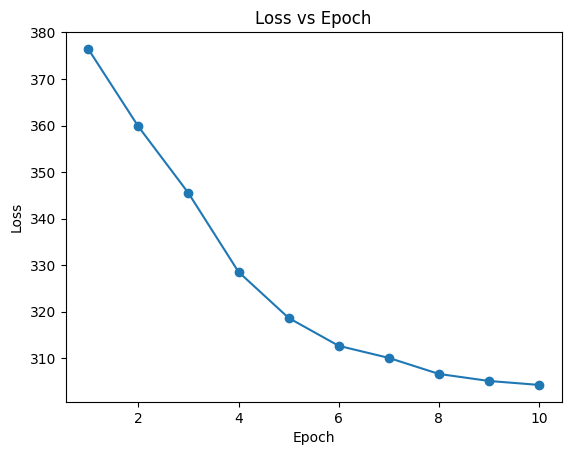

In [47]:
epochs = 10
epoch_numbers = list(range(1, epochs + 1))

# Plotting the loss with respect to epochs
plt.plot(epoch_numbers,loss_values , marker='o')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Display the plot
plt.show()

# Inferencing

In [ ]:
def find_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key

    return None

In [ ]:
def decode_input(encoded_input, token_to_int_mapping):
    decoded_input=[]
    for idx in encoded_input:
      if int(idx) !=0 and find_key_by_value(token_to_int_mapping, int(idx)) is not None:
        decoded_input.append(find_key_by_value(token_to_int_mapping, int(idx)))
    return decoded_input


In [ ]:
def inference(model,input_encoding):
    # Load the trained model
    # model = TransformerSeq2Seq(vocab_size_condition1=1000, vocab_size_condition2=1000, vocab_size_condition3=1000)
    # model_state_dict = torch.load('your_model_checkpoint.pth')
    # model.load_state_dict(model_state_dict)
    model = model.to(device)
    model.eval()


    # Create a placeholder tensor for target_sequence during inference
    placeholder_target = [torch.zeros((1,1,108)).long().to(device),torch.zeros((1,1,108)).long().to(device),torch.zeros((1,1,108)).long().to(device)]  # Adjust max_sequence_length accordingly7



    # Perform inference
    with torch.no_grad():
        # Pass only input_encoding and the placeholder_target to the model during inference
        output_probs_condition1, output_probs_condition2, output_probs_condition3 = model(input_encoding, targets=placeholder_target, train_mode=False)

    # Post-process output if necessary
    output_condition1 = output_probs_condition1.cpu().numpy()
    output_condition2 = output_probs_condition2.cpu().numpy()
    output_condition3 = output_probs_condition3.cpu().numpy()

    decoded_condition1 = decode_input(output_probs_condition1, token_to_int_mapping)
    decoded_condition2 = decode_input(output_probs_condition2, token_to_int_mapping)
    decoded_condition3 = decode_input(output_probs_condition3, token_to_int_mapping)

    reactant,product= separate_compounds(input_encoding)

    print("This is the original Reaction", input_encoding,'The reactant is ',reactant, 'The product is ',product)
    print("The Reagant of the original Reaction is",' '.join(decoded_condition1))
    print("The Solvent of the original Reaction is",' '.join(decoded_condition2))
    print("The Catalyst of the original Reaction is",' '.join(decoded_condition3))


    return output_condition1, output_condition2, output_condition3

In [ ]:
o1,o2,o3=inference(model,'CC(C)(C)OC(=O)N1CC2CC(CN(Cc3ccccc3)C2)C1>>CC(C)(C)OC(=O)N1CC2CNCC(C2)C1')

This is the original Reaction CC(C)(C)OC(=O)N1CC2CC(CN(Cc3ccccc3)C2)C1>>CC(C)(C)OC(=O)N1CC2CNCC(C2)C1 The reactant is  CC(C)(C)OC(=O)N1CC2CC(CN(Cc3ccccc3)C2)C1 The product is  CC(C)(C)OC(=O)N1CC2CNCC(C2)C1
The Reagant of the original Reaction is phosphorus iodide ; 0 methanol|water water|platinum palladium iv water|platinum ammonium ethanol|nickel peroxide|trifluoroacetic
The Solvent of the original Reaction is azide|cerium iodide|diisopropylamine
The Catalyst of the original Reaction is iodide|diisopropylamine sodium peroxide|trifluoroacetic


In [49]:
print(o1)

[133.81888    82.27891    55.428497   33.617363   46.942318   27.07669
  25.918028   12.986432   27.714197    9.720268    0.          4.500267
   6.9563093   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.

# Metrics

## Loss metrcis
On of the metrics that we reported is the loss metrics using MSE between the predicted and the original

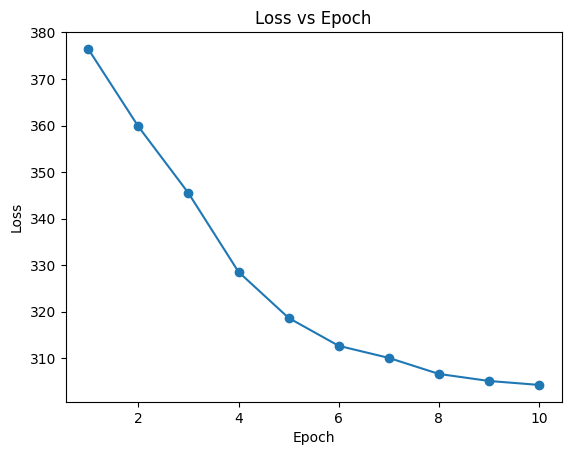

In [48]:
epochs = 10
epoch_numbers = list(range(1, epochs + 1))

# Plotting the loss with respect to epochs
plt.plot(epoch_numbers,loss_values , marker='o')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Display the plot
plt.show()

## R2-Squared

In [50]:
def calculate_r2_score(target, output):
    r2 = r2_score(target, output)
    return r2

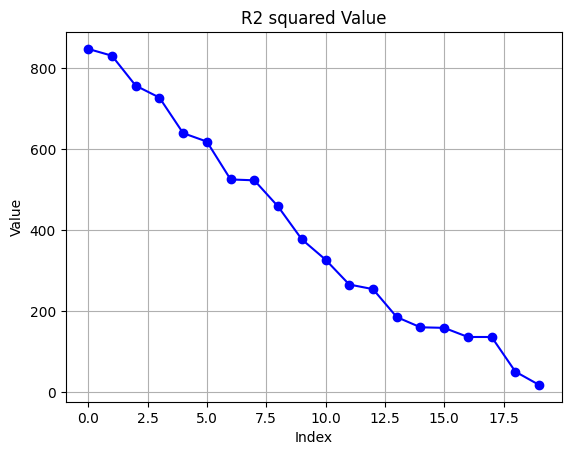

In [86]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as sklearn_r2_score

def calculate_r2_score(predictions, targets):
    r2 = sklearn_r2_score(targets, predictions)
    return r2

def r2_score_and_plot(model, dataloader):
    r2_scores_condition1 = []
    r2_scores_condition2 = []
    r2_scores_condition3 = []

    for inputs, targets in dataloader:
        inputs = inputs[0]
        placeholder_target = [torch.zeros((1,1,108)).long().to(device),
                              torch.zeros((1,1,108)).long().to(device),
                              torch.zeros((1,1,108)).long().to(device)]

        # Assuming your model returns three outputs for each condition
        output_condition1, output_condition2, output_condition3 = model(inputs, targets=placeholder_target)

        # Flatten the outputs and targets for R2 score calculation
        output_condition1 = output_condition1.view(-1).cpu().detach().numpy()
        output_condition2 = output_condition2.view(-1).cpu().detach().numpy()
        output_condition3 = output_condition3.view(-1).cpu().detach().numpy()

        targets_condition1 = targets[0].view(-1).cpu().numpy()
        targets_condition2 = targets[1].view(-1).cpu().numpy()
        targets_condition3 = targets[2].view(-1).cpu().numpy()

        # Calculate R2 scores for each condition
        r2_condition1 = calculate_r2_score(output_condition1, targets_condition1)
        r2_condition2 = calculate_r2_score(output_condition2, targets_condition2)
        r2_condition3 = calculate_r2_score(output_condition3, targets_condition3)

        # Append R2 scores to the lists
        r2_scores_condition1.append(r2_condition1+r2_condition2+r2_condition3)


    # Plot R2 scores for each condition
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(r2_scores_condition1, label='R2 Squared Value')
    plt.xlabel('Iterations')
    plt.ylabel('R2 Score')
    plt.title('R2 Score (Condition 1)')
    plt.legend()




    plt.tight_layout()
    plt.show()

    return r2_scores_condition1, r2_scores_condition2, r2_scores_condition3


## KL Divergence

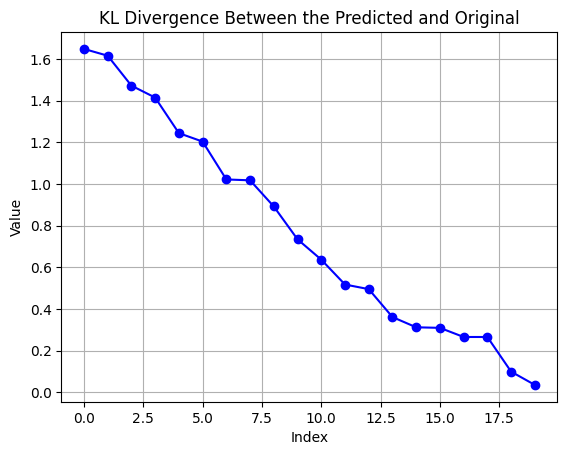

In [89]:
def calculate_kl_divergence(predictions, targets):
    kl_divergence = F.kl_div(predictions.log(), targets, reduction='sum')
    return kl_divergence.item()

def kl_divergence_and_plot(model, dataloader):
    kl_divergence_condition1 = []
    kl_divergence_condition2 = []
    kl_divergence_condition3 = []

    for inputs, targets in dataloader:
        inputs = inputs[0]
        placeholder_target = [torch.zeros((1,1,108)).long().to(device),
                              torch.zeros((1,1,108)).long().to(device),
                              torch.zeros((1,1,108)).long().to(device)]

        # Assuming your model returns three outputs for each condition
        output_condition1, output_condition2, output_condition3 = model(inputs, targets=placeholder_target)

        # Calculate KL Divergence for each condition
        kl_divergence_condition1_value = calculate_kl_divergence(output_condition1, targets[0])
        kl_divergence_condition2_value = calculate_kl_divergence(output_condition2, targets[1])
        kl_divergence_condition3_value = calculate_kl_divergence(output_condition3, targets[2])

        # Append KL Divergence values to the lists
        kl_divergence_condition1.append(kl_divergence_condition1_value)
        kl_divergence_condition2.append(kl_divergence_condition2_value)
        kl_divergence_condition3.append(kl_divergence_condition3_value)

    # Plot KL Divergence for each condition
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(kl_divergence_condition1, label='Kl divergence Between predicted and Original')


    plt.tight_layout()
    plt.show()

    return kl_divergence_condition1, kl_divergence_condition2, kl_divergence_condition3
